# Test weak form PDE functionality on Reaction-Diffusion system

The reaction-diffusion system exhibits spiral waves on a periodic domain,and the PDEs are:
$$u_t = d_1\nabla^2 u + (1-A^2)u +\beta A^2v$$
$$v_t = d_2\nabla^2 v - \beta A^2 u + (1-A^2)v$$
$$A^2 = u^2 + v^2.$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps
from scipy.io import loadmat
from scipy.integrate import solve_ivp

Below I take the example from `pysindy/examples/12_weakform_SINDy_examples.ipynb` but make the example not symmetric with respect to `x` and `y`. For example, I increase the gradient with respect to `x` by factor `4` for both `u` and `v`. I also make domain size and dimension not symmetric. As a consequence I had to modify the code very slightly to make it work.

kx.shape = (128,), ky.shape = (64,)


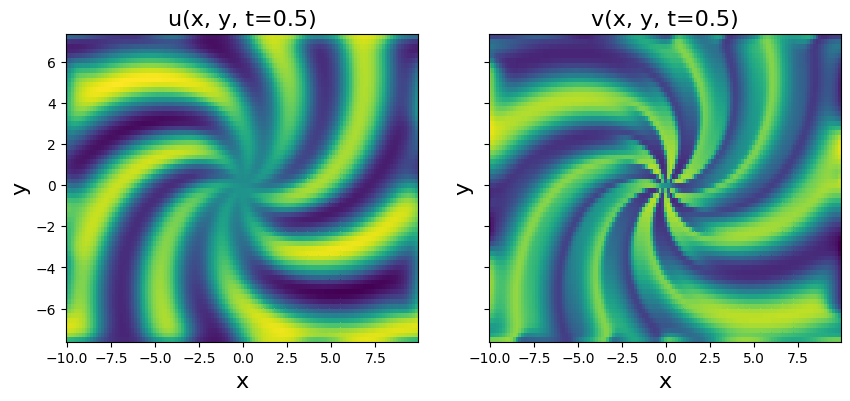

In [2]:
# Define the reaction-diffusion PDE in the Fourier (kx, ky) space
def reaction_diffusion(t, uvt, K22, d1, d2, beta, nx, ny, N):
    ut = np.reshape(uvt[:N], (nx, ny))
    vt = np.reshape(uvt[N : 2 * N], (nx, ny))
    u = np.real(np.fft.ifft2(ut))
    v = np.real(np.fft.ifft2(vt))
    u3 = u**3
    v3 = v**3
    u2v = (u**2) * v
    uv2 = u * (v**2)
    utrhs = np.reshape((np.fft.fft2(u - u3 - uv2 + beta * u2v + beta * v3)), (N, 1))
    vtrhs = np.reshape((np.fft.fft2(v - u2v - v3 - beta * u3 - beta * uv2)), (N, 1))
    uvt_reshaped = np.reshape(uvt, (len(uvt), 1))
    uvt_updated = np.squeeze(
        np.vstack(
            (-d1 * K22 * uvt_reshaped[:N] + utrhs, -d2 * K22 * uvt_reshaped[N:] + vtrhs)
        )
    )
    return uvt_updated


# Generate the data
t = np.linspace(0, 10, int(10 / 0.1))
d1 = 0.2
d2 = 0
beta = 3.0
Lx = 20  # Domain size in X
Ly = 15  # Domain size in Y
nx = 128  # Number of spatial points in each direction
ny = 64  # Number of spatial points in each direction
N = nx * ny
x_uniform = np.linspace(-Lx / 2, Lx / 2, nx + 1)
y_uniform = np.linspace(-Ly / 2, Ly / 2, ny + 1)
x = x_uniform[:nx]
y = y_uniform[:ny]
n2x = int(nx / 2)
n2y = int(ny / 2)
# Define Fourier wavevectors (kx, ky)
kx = 2*(2 * np.pi / Lx) * np.hstack((np.linspace(0, n2x - 1, n2x), np.linspace(-n2x, -1, n2x)))
ky = (2 * np.pi / Ly) * np.hstack((np.linspace(0, n2y - 1, n2y), np.linspace(-n2y, -1, n2y)))
print(f"{kx.shape = }, {ky.shape = }")
# Get 2D meshes in (x, y) and (kx, ky)
X, Y = np.meshgrid(x, y, indexing="ij")
KX, KY = np.meshgrid(kx, ky, indexing="ij")
K2 = KX**2 + KY**2
K22 = np.reshape(K2, (N, 1))

m = 7  # number of spirals

# define our solution vectors
u = np.zeros((len(x), len(y), len(t)))
v = np.zeros((len(x), len(y), len(t)))

# Initial conditions
u[:, :, 0] = np.tanh(np.sqrt(X**2 + Y**2)) * np.cos(
    m * np.angle(X + 1j * Y) - (np.sqrt(X**2 + Y**2))
)
v[:, :, 0] = np.tanh(np.sqrt(X**2 + Y**2)) * np.sin(
    m * np.angle(X + 1j * Y) - (np.sqrt(X**2 + Y**2))
)

# uvt is the solution vector in Fourier space, so below
# we are initializing the 2D FFT of the initial condition, uvt0
uvt0 = np.squeeze(
    np.hstack(
        (np.reshape(np.fft.fft2(u[:, :, 0]), (1, N)), np.reshape(np.fft.fft2(v[:, :, 0]), (1, N)))
    )
)

# Solve the PDE in the Fourier space, where it reduces to system of ODEs
uvsol = solve_ivp(
    reaction_diffusion, (t[0], t[-1]), y0=uvt0, t_eval=t, args=(K22, d1, d2, beta, nx, ny, N)
)
uvsol = uvsol.y

# Reshape things and ifft back into (x, y, t) space from (kx, ky, t) space
for j in range(len(t)):
    ut = np.reshape(uvsol[:N, j], (nx, ny))
    vt = np.reshape(uvsol[N:, j], (nx, ny))
    u[:, :, j] = np.real(np.fft.ifft2(ut))
    v[:, :, j] = np.real(np.fft.ifft2(vt))

# Plot to check if spiral is nicely reproduced
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolor(X, Y, u[:, :, 10])
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.title("u(x, y, t=0.5)", fontsize=16)
plt.subplot(1, 2, 2)
plt.pcolor(X, Y, v[:, :, 10])
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title("v(x, y, t=0.5)", fontsize=16)

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]

u_sol = u
v_sol = v

Text(0.5, 1.0, '$\\partial u(x, y, t=0.5)/\\partial x$')

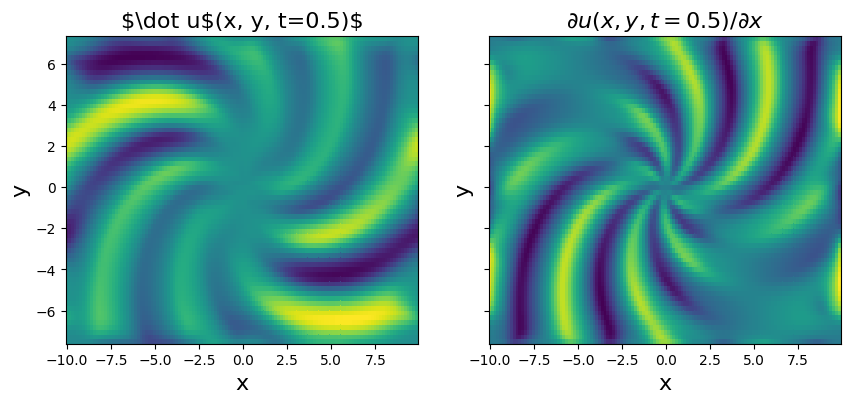

In [3]:
u_dot = ps.FiniteDifference(axis=2)._differentiate(u, t=dt)
dudx = ps.FiniteDifference(axis=0)._differentiate(u, t=dx)
# Plot to check if spiral is nicely reproduced
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolor(X, Y, u_dot[:, :, 10])
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.title("$\dot u$(x, y, t=0.5)$", fontsize=16)
plt.subplot(1, 2, 2)
plt.pcolor(X, Y, dudx[:, :, 10])
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title("$\partial u(x, y, t=0.5)/\partial x$", fontsize=16)

In [4]:
sol = np.zeros((nx, ny, len(t), 2))
sol[:, :, :, 0] = u_sol
sol[:, :, :, 1] = v_sol

# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]

np.random.seed(100)
# Need to define the 2D spatial grid before calling the library
X3D, Y3D, T3D = np.meshgrid(x, y, t, indexing="ij")
XYT = np.transpose([X3D, Y3D, T3D], [1, 2, 3, 0])
weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XYT,
    is_uniform=True,
    periodic=True,
    K=100,
    include_interaction=False,
)

In [5]:
print(f"{X.shape = }, {Y.shape = }, {XYT.shape = }, {sol.shape = }")

X.shape = (128, 64), Y.shape = (128, 64), XYT.shape = (128, 64, 100, 3), sol.shape = (128, 64, 100, 2)


In [6]:
# Fit the 2D reaction-diffusion equation, weak form style!
optimizer = ps.STLSQ(threshold=0.05, alpha=1e-5) #, normalize_columns=True)
model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer)
model.fit(sol)
model.print()

(x0)' = 1.001 x0 + -1.000 x0x0x0 + 3.000 x1x1x1 + -1.001 x0x1x1 + 3.000 x0x0x1 + 0.200 x0_22 + 0.800 x0_11
(x1)' = 1.000 x1 + -3.000 x0x0x0 + -1.000 x1x1x1 + -3.000 x0x1x1 + -1.000 x0x0x1


In [6]:
# Fit the 2D reaction-diffusion equation, weak form style!
optimizer = ps.STLSQ(threshold=0.05, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer)
model.fit(sol)
model.print()

(x0)' = 1.001 x0 + -1.000 x0x0x0 + 3.000 x1x1x1 + -1.001 x0x1x1 + 3.000 x0x0x1 + 0.200 x0_22 + 0.800 x0_11
(x1)' = 1.000 x1 + -3.000 x0x0x0 + -1.000 x1x1x1 + -3.000 x0x1x1 + -1.000 x0x0x1


## Treating `u` like a source

Suppose we don't want to optimize to find the PDE for `u` but would rather use it only as input to the PDE to `v`

In [7]:
# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x * x
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x
]

np.random.seed(100)
# Need to define the 2D spatial grid before calling the library
X3D, Y3D, T3D = np.meshgrid(x, y, t, indexing="ij")
XYT = np.transpose([X3D, Y3D, T3D], [1, 2, 3, 0])
weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XYT,
    is_uniform=True,
    periodic=True,
    K=100,
    include_interaction=False,
)

In [8]:
# Fit the 2D reaction-diffusion equation, weak form style!
for threhsold in [0.001,0.002,0.005,0.009,0.01,0.015,0.02,0.05,0.1,0.2,0.5,1]:
    optimizer = ps.STLSQ(threshold=threhsold, alpha=1e-5)#, normalize_columns=True)
    model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer)
    model.fit(v_sol[...,np.newaxis], u=u_sol[...,np.newaxis])
    model.print()

(x0)' = 0.842 x0 + -0.815 u0 + -1.204 x0x0x0 + -2.543 u0u0u0 + -0.009 x0_2 + 0.021 u0_2 + 0.003 x0_22 + -0.006 u0_22 + -0.006 x0_1 + 0.026 u0_1 + 0.007 x0_12 + 0.009 u0_12 + 0.020 x0_11 + -0.153 u0_11
(x0)' = 0.842 x0 + -0.815 u0 + -1.204 x0x0x0 + -2.543 u0u0u0 + -0.009 x0_2 + 0.021 u0_2 + 0.003 x0_22 + -0.006 u0_22 + -0.006 x0_1 + 0.026 u0_1 + 0.007 x0_12 + 0.009 u0_12 + 0.020 x0_11 + -0.153 u0_11
(x0)' = 0.829 x0 + -0.804 u0 + -1.190 x0x0x0 + -2.542 u0u0u0 + -0.008 x0_2 + 0.018 u0_2 + -0.006 x0_1 + 0.025 u0_1 + 0.005 x0_12 + 0.012 u0_12 + 0.019 x0_11 + -0.151 u0_11
(x0)' = 0.831 x0 + -0.800 u0 + -1.190 x0x0x0 + -2.538 u0u0u0 + 0.016 u0_2 + 0.023 u0_1 + 0.018 x0_11 + -0.144 u0_11
(x0)' = 0.831 x0 + -0.800 u0 + -1.190 x0x0x0 + -2.538 u0u0u0 + 0.016 u0_2 + 0.023 u0_1 + 0.018 x0_11 + -0.144 u0_11
(x0)' = 0.831 x0 + -0.800 u0 + -1.190 x0x0x0 + -2.538 u0u0u0 + 0.016 u0_2 + 0.023 u0_1 + 0.018 x0_11 + -0.144 u0_11
(x0)' = 0.813 x0 + -0.735 u0 + -1.176 x0x0x0 + -2.605 u0u0u0 + -0.073 u0_11
(x

In [23]:
# Fit the 2D reaction-diffusion equation, weak form style!
for threhsold in [0.001,0.002,0.005,0.009,0.01,0.015,0.02,0.05,0.1,0.2,0.5,1]:
    optimizer = ps.STLSQ(threshold=threhsold, alpha=1e-5, normalize_columns=True)
    model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer)
    model.fit(v_sol[...,np.newaxis], u=u_sol[...,np.newaxis])
    model.print()

(x0)' = 0.842 x0 + -0.815 u0 + -1.204 x0x0x0 + -2.543 u0u0u0 + -0.009 x0_2 + 0.021 u0_2 + 0.003 x0_22 + -0.006 u0_22 + -0.006 x0_1 + 0.026 u0_1 + 0.007 x0_12 + 0.009 u0_12 + 0.020 x0_11 + -0.153 u0_11
(x0)' = 0.842 x0 + -0.815 u0 + -1.204 x0x0x0 + -2.543 u0u0u0 + -0.009 x0_2 + 0.021 u0_2 + 0.003 x0_22 + -0.006 u0_22 + -0.006 x0_1 + 0.026 u0_1 + 0.007 x0_12 + 0.009 u0_12 + 0.020 x0_11 + -0.153 u0_11
(x0)' = 0.844 x0 + -0.821 u0 + -1.207 x0x0x0 + -2.534 u0u0u0 + -0.009 x0_2 + 0.021 u0_2 + 0.003 x0_22 + -0.007 u0_22 + -0.006 x0_1 + 0.026 u0_1 + 0.009 x0_12 + 0.020 x0_11 + -0.155 u0_11
(x0)' = 0.828 x0 + -0.810 u0 + -1.193 x0x0x0 + -2.523 u0u0u0 + 0.014 u0_2 + 0.009 x0_12 + 0.019 x0_11 + -0.152 u0_11
(x0)' = 0.835 x0 + -0.816 u0 + -1.194 x0x0x0 + -2.518 u0u0u0 + 0.009 x0_12 + 0.020 x0_11 + -0.152 u0_11
(x0)' = 0.838 x0 + -0.805 u0 + -1.192 x0x0x0 + -2.534 u0u0u0 + 0.018 x0_11 + -0.143 u0_11
(x0)' = 0.838 x0 + -0.805 u0 + -1.192 x0x0x0 + -2.534 u0u0u0 + 0.018 x0_11 + -0.143 u0_11
(x0)' = 0.

`problem`: derivaives with respect to `u` do not appear for some reason

(x0)' = 1.001 x0 + -1.000 x0x0x0 + 3.000 x1x1x1 + -1.001 x0x1x1 + 3.000 x0x0x1 + 0.200 x0_22 + 0.800 x0_11